Sim done. Rho=9.831, Time=616248.4

=== Q TABLE (Detailed) ===

--- Country 1 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |------------------------------|--------
       0   | 55797.67 | 55735.26 | 56134.91 | 56585.01 | 56802.81 |  4
       1   | 56053.55 | 56018.52 | 56154.06 | 56641.59 | 56521.91 |  3
       2   | 55626.69 | 55563.01 | 56178.62 | 56126.73 | 56432.10 |  4
       3   | 55458.11 | 55748.21 | 55629.78 | 56249.75 | 56312.47 |  4
       4   | 55678.57 | 55817.28 | 56178.32 | 56066.94 | 56461.56 |  4

--- Country 2 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |------------------------------|--------
       0   | 37992.47 | 37960.22 | 37831.13 | 38307.13 | 38576.20 |  4
       1   | 38293.11 | 37701.19 | 37679.09 | 38309.32 | 38805.14 |  4
       2   | 38255.27 | 37643.85 | 38124.26 | 38588.06 | 38751.09 |  4
       3   | 38375.37 | 37801.73 | 38149.97 | 38532.25 | 38754.07 |  4
       4   | 38426.73 | 37919.21 | 38195.35 | 3818

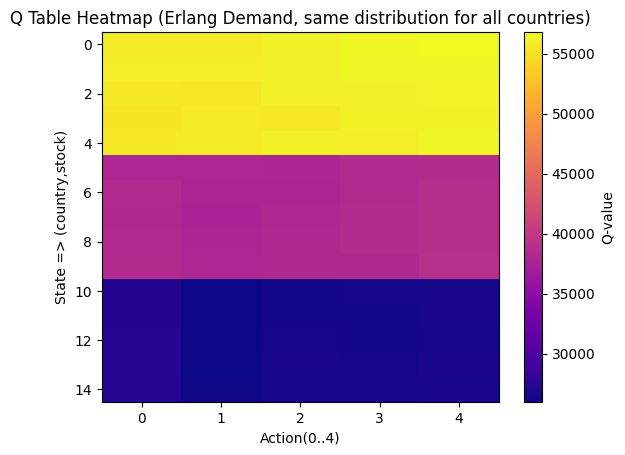

In [1]:
 import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import csv  # Optional: for writing Q-table to a CSV

###############################################################################
# PARAMETERS: Three countries, each with the SAME moderate-variability Erlang 
# demand pattern. For instance, k=5, beta=1.0 => mean=5, CV~0.45.
###############################################################################
random.seed(42)

def random_exchange(country_idx):
    """
    i=0 => Country1 => 0.4..0.6
    i=1 => Country2 => 0.9..1.1
    i=2 => Country3 => 1.9..2.1
    """
    if country_idx == 0:
        return random.uniform(0.4, 0.6)
    elif country_idx == 1:
        return random.uniform(0.9, 1.1)
    else:
        return random.uniform(1.9, 2.1)

# Cost Parameters
m = 300         # production cost
p = 500         # sale price
TARIFF = 0.15   # tariff rate
I = 10          # inventory cost rate
c = 6           # pipeline cost per time
late_penalty = 3
it_list = [0.1715, 0.3430, 0.6860]  # inventory times for countries 1..3

def production_time():
    return random.uniform(1, 3)

def transport_time(action):
    """
    action=0 => local => 1..3
    action=1,3 => slow => 15..17
    action=2,4 => fast => 3..5
    """
    if action == 0:
        return random.uniform(1, 3)
    elif action in [1, 3]:
        return random.uniform(15, 17)
    else:
        return random.uniform(3, 5)

def get_j(i, action):
    """
    Maps origin i and chosen action to a 'destination' j.
    Action 0 => local shipping (j=i).

    i=0 (Country1):
      actions 1,2 => j=1
      actions 3,4 => j=2
    i=1 (Country2):
      actions 1,2 => j=0
      actions 3,4 => j=2
    i=2 (Country3):
      actions 1,2 => j=0
      actions 3,4 => j=1
    """
    if action == 0:
        return i
    if i == 0:
        if action in [1, 2]:
            return 1
        else:
            return 2
    elif i == 1:
        if action in [1, 2]:
            return 0
        else:
            return 2
    else:
        if action in [1, 2]:
            return 0
        else:
            return 1

###############################################################################
# Q TABLE
###############################################################################
NUM_COUNTRY = 3
NUM_STOCK   = 5
NUM_ACTION  = 5
Q = np.zeros((NUM_COUNTRY, NUM_STOCK, NUM_ACTION))

ALPHA      = 0.1
GAMMA      = 1.0
EPSILON    = 1.0
EPS_DECAY  = 0.999999
EPS_MIN    = 0.01

def best_action(i, s):
    return np.argmax(Q[i, s, :])

def select_action(i, s):
    global EPSILON
    if random.random() < EPSILON:
        return random.randint(0,4)
    else:
        return best_action(i,s)

###############################################################################
# AVERAGE REWARD
###############################################################################
TOTAL_REWARD = 0.0
TOTAL_TIME   = 0.0
rho          = 0.0

def update_q(i, s, a, reward, dt, i_next, s_next):
    global TOTAL_REWARD, TOTAL_TIME, rho
    oldQ = Q[i, s, a]
    bestNxt = np.max(Q[i_next, s_next, :])
    Q[i, s, a] = (1 - ALPHA)*oldQ + ALPHA*(reward - rho*dt + bestNxt)

    TOTAL_REWARD += reward
    TOTAL_TIME   += dt
    T = max(TOTAL_TIME, 1e-9)
    rho = TOTAL_REWARD / T

###############################################################################
# REWARD FUNCTION
###############################################################################
def compute_reward(i, a, s):
    pt = production_time()
    st = transport_time(a)
    total_t = pt + st
    late = (total_t > 10)

    j = get_j(i, a)

    ex_i = random_exchange(i)
    ex_j = random_exchange(j)

    revenue = ex_j * p
    cost    = ex_i*m + I*ex_i*it_list[i] + c*(pt+st) + I*ex_j*it_list[j]

    if i != j:
        cost += TARIFF * ex_j * p
    if late:
        cost += ex_j * late_penalty

    return revenue - cost, total_t, late

###############################################################################
# DEMAND PROCESS
###############################################################################
def demand_process(env, demand_id, i_country):
    s = random.randint(0,4)
    a = select_action(i_country, s)
    r, dt, late = compute_reward(i_country, a, s)

    s_next = s - 1 if s>0 else 0
    i_next = i_country

    yield env.timeout(dt)
    update_q(i_country, s, a, r, dt, i_next, s_next)

    global EPSILON
    if EPSILON > EPS_MIN:
        EPSILON *= EPS_DECAY

###############################################################################
# ERLANG DEMAND ARRIVALS (SAME DISTRIBUTION FOR ALL COUNTRIES)
###############################################################################
def arrival_process_i(env, i_country, k_shape, beta_scale):
    d_id = 0
    while True:
        inter = random.gammavariate(k_shape, beta_scale)  # Erlang/Gamma
        yield env.timeout(inter)
        d_id += 1
        env.process(demand_process(env, d_id, i_country))

###############################################################################
def main():
    random.seed(42)
    env = simpy.Environment()

    # We'll use a single Erlang(k=5, beta=1) distribution for all countries
    # => mean= k*beta=5, CV=1/sqrt(k)~0.45 => moderate variability
    k_shape   = 5
    beta_scale= 1.0

    for i_country in range(NUM_COUNTRY):
        env.process(arrival_process_i(env, i_country, k_shape, beta_scale))

    SIM_TIME = 100000
    env.run(until=SIM_TIME)

    print(f"Sim done. Rho={rho:.3f}, Time={TOTAL_TIME:.1f}")

    ###########################################################################
    # 1) PRINT Q TABLE IN A TABULAR FORMAT
    ###########################################################################
    print("\n=== Q TABLE (Detailed) ===")
    action_labels = ["A0(local)", "A1", "A2", "A3", "A4"]
    for i_ in range(NUM_COUNTRY):
        print(f"\n--- Country {i_+1} ---")
        print("     Stock |", " | ".join(action_labels), "| bestAct")
        print("    ------ |------------------------------|--------")
        for s_ in range(NUM_STOCK):
            row_vals = Q[i_, s_, :]
            row_rounded = [f"{val:.2f}" for val in row_vals]
            bestA = np.argmax(row_vals)
            print(f"      {s_:>2}   |", " | ".join(row_rounded), f"|  {bestA}")

    ###########################################################################
    # 2) (Optional) WRITE Q TABLE TO A CSV FILE
    #    Each row => i_country, s_stock, Q(a=0..4)
    ###########################################################################
    with open("Qtable_export.csv", mode="w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["country", "stock", "action0", "action1", 
                         "action2", "action3", "action4", "bestAction"])
        for i_ in range(NUM_COUNTRY):
            for s_ in range(NUM_STOCK):
                row_vals = Q[i_, s_, :]
                bestA = np.argmax(row_vals)
                writer.writerow([i_+1, s_] + row_vals.round(2).tolist() + [bestA])
    print("\n(Q-table also written to 'Qtable_export.csv')")

    ###########################################################################
    # 3) PLOT HEATMAP
    ###########################################################################
    arr_2d= Q.reshape(NUM_COUNTRY*NUM_STOCK, NUM_ACTION)
    plt.figure()
    plt.imshow(arr_2d, cmap='plasma', aspect='auto')
    plt.colorbar(label="Q-value")
    plt.xlabel("Action(0..4)")
    plt.ylabel("State => (country,stock)")
    plt.title("Q Table Heatmap (Erlang Demand, same distribution for all countries)")
    plt.show()

if __name__=="__main__":
    main()

Sim done. Rho=5.729, Time=613548.4

=== Q TABLE (Detailed) ===

--- Country 1 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |--------------------------------------|--------
       0   | 11669.72 | 11427.81 | 11593.90 | 11417.57 | 11548.73 |  0
       1   | 11712.63 | 11481.70 | 11607.85 | 11407.87 | 11452.70 |  0
       2   | 11648.60 | 11452.73 | 11683.33 | 11392.84 | 11502.95 |  2
       3   | 11685.69 | 11497.28 | 11599.06 | 11442.73 | 11493.52 |  0
       4   | 11675.88 | 11521.64 | 11718.05 | 11409.78 | 11584.26 |  2

--- Country 2 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |--------------------------------------|--------
       0   | 12138.90 | 11938.90 | 12008.87 | 11825.58 | 11948.29 |  0
       1   | 12200.02 | 11853.55 | 11954.85 | 11817.45 | 12040.80 |  0
       2   | 12239.07 | 11878.84 | 12105.46 | 11924.77 | 12014.54 |  0
       3   | 12311.24 | 11967.88 | 12151.85 | 11952.27 | 12022.63 |  0
       4   | 12387.64 | 12088.60 |

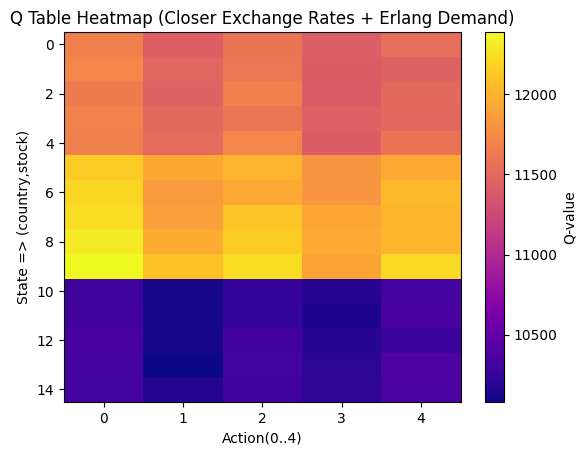

In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import csv  # <-- added for CSV export

###############################################################################
# PARAMETERS: Three countries with closer exchange rates,
# and Erlang(k=5, beta=1) demand arrivals (moderate variability).
###############################################################################
random.seed(42)

def random_exchange(country_idx):
    """
    Closer exchange rates:
      i=0 => ülke1 => 0.8..1.0
      i=1 => ülke2 => 0.9..1.1
      i=2 => ülke3 => 0.7..0.9
    """
    if country_idx == 0:
        return random.uniform(0.8,1.0)
    elif country_idx == 1:
        return random.uniform(0.9,1.1)
    else:  # i=2
        return random.uniform(0.7,0.9)

m            = 300
p            = 500
TARIFF       = 0.15
I            = 10
c            = 6
late_penalty = 3

# inventory time factors for countries i=0..2
it_list      = [0.1715, 0.3430, 0.6860]

def production_time():
    return random.uniform(1, 3)

def transport_time(action):
    """
    action=0 => local => 1..3
    action=1,3 => slow => 15..17
    action=2,4 => fast => 3..5
    """
    if action == 0:
        return random.uniform(1, 3)
    elif action in [1,3]:
        return random.uniform(15,17)
    else:
        return random.uniform(3,5)

def get_j(i, action):
    """
    Determines the 'supplying' country j, given the 'current' country i
    and chosen action:
      action=0 => local shipping (j=i)
      
      For i=0 (Country 1):
        actions 1,2 => from Country 2
        actions 3,4 => from Country 3
      For i=1 (Country 2):
        actions 1,2 => from Country 1
        actions 3,4 => from Country 3
      For i=2 (Country 3):
        actions 1,2 => from Country 1
        actions 3,4 => from Country 2
    """
    if action == 0:
        return i
    if i == 0:
        if action in [1, 2]:
            return 1
        else:
            return 2
    elif i == 1:
        if action in [1, 2]:
            return 0
        else:
            return 2
    else:  # i==2
        if action in [1, 2]:
            return 0
        else:
            return 1

###############################################################################
# Q TABLE & RL VARIABLES
###############################################################################
NUM_COUNTRY = 3
NUM_STOCK   = 5
NUM_ACTION  = 5
Q = np.zeros((NUM_COUNTRY, NUM_STOCK, NUM_ACTION))

ALPHA      = 0.1
GAMMA      = 1.0
EPSILON    = 1.0
EPS_DECAY  = 0.999999
EPS_MIN    = 0.01

def best_action(i, s):
    return np.argmax(Q[i, s, :])

def select_action(i, s):
    global EPSILON
    if random.random() < EPSILON:
        return random.randint(0, 4)
    else:
        return best_action(i, s)

###############################################################################
# AVERAGE REWARD
###############################################################################
TOTAL_REWARD = 0.0
TOTAL_TIME   = 0.0
rho          = 0.0  

def update_q(i, s, a, reward, dt, i_next, s_next):
    global TOTAL_REWARD, TOTAL_TIME, rho
    oldQ    = Q[i, s, a]
    bestNxt = np.max(Q[i_next, s_next, :])
    # Q update => average reward style
    Q[i, s, a] = (1 - ALPHA)*oldQ + ALPHA*(reward - rho*dt + bestNxt)

    TOTAL_REWARD += reward
    TOTAL_TIME  += dt
    T = max(TOTAL_TIME, 1e-9)
    rho = TOTAL_REWARD / T

###############################################################################
# REWARD FUNCTION
###############################################################################
def compute_reward(i, a, s):
    """
    r = e_j * p
        - [e_i*m + I*e_i*it_list[i] + c*(pt+st) + I*e_j*it_list[j]]
        - Tariff if i!=j
        - Late penalty if total_t>10
    """
    pt      = production_time()
    st      = transport_time(a)
    total_t = pt + st
    late    = (total_t > 10)

    j = get_j(i, a)

    ex_i = random_exchange(i)
    ex_j = random_exchange(j)

    revenue = ex_j * p
    cost    = ex_i*m + I*ex_i*it_list[i] + c*(pt+st) + I*ex_j*it_list[j]

    if i != j:
        cost += TARIFF * ex_j * p
    if late:
        cost += ex_j* late_penalty

    return (revenue - cost), total_t, late

###############################################################################
# DEMAND PROCESS
###############################################################################
def demand_process(env, demand_id, i_country):
    s = random.randint(0, 4)
    a = select_action(i_country, s)
    r, dt, late = compute_reward(i_country, a, s)

    s_next = s-1 if s>0 else 0
    i_next = i_country

    yield env.timeout(dt)
    update_q(i_country, s, a, r, dt, i_next, s_next)

    global EPSILON
    if EPSILON> EPS_MIN:
        EPSILON *= EPS_DECAY

###############################################################################
# ERLANG DEMAND ARRIVALS (SAME DIST. FOR ALL COUNTRIES)
###############################################################################
def arrival_process_i(env, i_country, k_shape, beta_scale):
    d_id = 0
    while True:
        # Erlang( k_shape, beta_scale ) => moderate variability
        inter = random.gammavariate(k_shape, beta_scale)
        yield env.timeout(inter)
        d_id += 1
        env.process(demand_process(env, d_id, i_country))

###############################################################################
def main():
    random.seed(42)
    env = simpy.Environment()

    # We'll use the same Erlang distribution for all countries:
    # k=5 => shape=5, beta=1.0 => mean=5, CV=~0.45 => moderate variability
    k_shape    = 5
    beta_scale = 1.0

    # Start arrivals
    for i_country in range(NUM_COUNTRY):
        env.process(arrival_process_i(env, i_country, k_shape, beta_scale))

    SIM_TIME = 100000
    env.run(until=SIM_TIME)

    print(f"Sim done. Rho={rho:.3f}, Time={TOTAL_TIME:.1f}")
    
    ###########################################################################
    # 1) PRINT Q TABLE IN A TABULAR FORMAT
    ###########################################################################
    print("\n=== Q TABLE (Detailed) ===")
    action_labels = ["A0(local)", "A1", "A2", "A3", "A4"]
    for i_ in range(NUM_COUNTRY):
        print(f"\n--- Country {i_+1} ---")
        print("     Stock |", " | ".join(action_labels), "| bestAct")
        print("    ------ |--------------------------------------|--------")
        for s_ in range(NUM_STOCK):
            row_vals = Q[i_, s_, :]
            row_rounded = [f"{val:.2f}" for val in row_vals]
            bestA = np.argmax(row_vals)
            print(f"      {s_:>2}   |", " | ".join(row_rounded), f"|  {bestA}")

    ###########################################################################
    # 2) (Optional) WRITE Q TABLE TO A CSV FILE
    ###########################################################################
    with open("Qtable_export_closerErlang.csv", mode="w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["country", "stock", "action0", "action1",
                         "action2", "action3", "action4", "bestAction"])
        for i_ in range(NUM_COUNTRY):
            for s_ in range(NUM_STOCK):
                row_vals = Q[i_, s_, :]
                bestA = np.argmax(row_vals)
                writer.writerow([i_+1, s_] 
                                + row_vals.round(2).tolist() 
                                + [bestA])
    print("\n(Q-table also written to 'Qtable_export_closerErlang.csv')")

    ###########################################################################
    # 3) PLOT HEATMAP
    ###########################################################################
    arr_2d = Q.reshape(NUM_COUNTRY * NUM_STOCK, NUM_ACTION)
    plt.figure()
    plt.imshow(arr_2d, cmap='plasma', aspect='auto')
    plt.colorbar(label="Q-value")
    plt.xlabel("Action(0..4)")
    plt.ylabel("State => (country,stock)")
    plt.title("Q Table Heatmap (Closer Exchange Rates + Erlang Demand)")
    plt.show()

if __name__ == "__main__":
    main()


Sim done. Rho=4.484, Time=613112.4

=== Q TABLE (Detailed) ===

--- Country 1 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |--------------------------------------|--------
       0   | 12635.99 | 12435.77 | 12588.43 | 12422.53 | 12538.60 |  0
       1   | 12680.25 | 12491.59 | 12602.34 | 12413.40 | 12439.54 |  0
       2   | 12615.54 | 12461.90 | 12680.22 | 12398.07 | 12491.98 |  2
       3   | 12673.93 | 12526.96 | 12608.40 | 12472.45 | 12500.39 |  0
       4   | 12650.28 | 12543.50 | 12730.19 | 12420.97 | 12584.04 |  2

--- Country 2 ---
     Stock | A0(local) | A1 | A2 | A3 | A4 | bestAct
    ------ |--------------------------------------|--------
       0   | 12559.73 | 12380.48 | 12431.44 | 12264.04 | 12370.90 |  0
       1   | 12622.40 | 12292.89 | 12376.09 | 12255.44 | 12467.23 |  0
       2   | 12663.00 | 12317.49 | 12531.50 | 12365.93 | 12439.72 |  0
       3   | 12737.03 | 12409.21 | 12579.32 | 12394.63 | 12447.82 |  0
       4   | 12815.02 | 12533.38 |

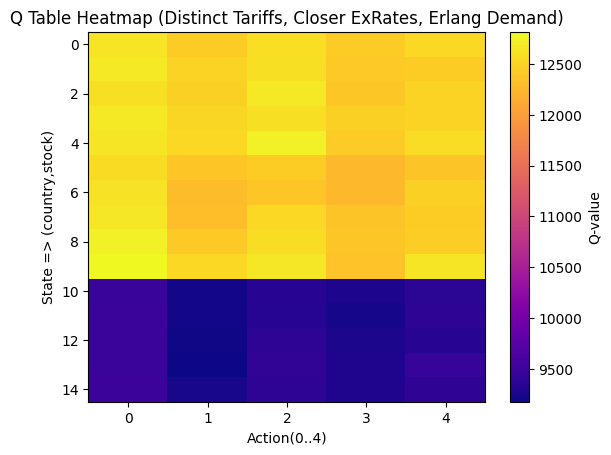

In [3]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import csv  # <-- for CSV export

###############################################################################
# PARAMETERS: 3 countries, closer exchange rates, distinct tariffs, 
# and Erlang-distributed demand arrivals for each country.
###############################################################################
random.seed(42)

# Closer exchange rates for each country:
#   country1 => 0.8..1.0
#   country2 => 0.9..1.1
#   country3 => 0.7..0.9
def random_exchange(country_idx):
    if country_idx == 0:    # country1
        return random.uniform(0.8, 1.0)
    elif country_idx == 1:  # country2
        return random.uniform(0.9, 1.1)
    else:                   # country3
        return random.uniform(0.7, 0.9)

# Distinct tariffs per country: [0.10, 0.15, 0.30]
TARIFFS = [0.10, 0.15, 0.30]

# Cost parameters
m = 300     # production cost
p = 500     # sale price
I = 10      # inventory cost rate
c = 6       # pipeline cost
late_penalty = 3

# Inventory time factors for countries i=0..2
it_list = [0.1715, 0.3430, 0.6860]

###############################################################################
# Production & Transport Times
###############################################################################
def production_time():
    return random.uniform(1, 3)

def transport_time(action):
    """
    action=0 => local => 1..3
    action=1,3 => slow => 15..17
    action=2,4 => fast => 3..5
    """
    if action == 0:
        return random.uniform(1, 3)
    elif action in [1,3]:
        return random.uniform(15,17)
    else:
        return random.uniform(3,5)

###############################################################################
# get_j FUNCTION
###############################################################################
def get_j(i, action):
    """
    Determines the 'destination' or 'selling' country j, given the origin i 
    and chosen action:
      - action=0 => local (j=i)

    For i=0 (Country 1):
      actions 1,2 => j=1 (Country 2)
      actions 3,4 => j=2 (Country 3)
    For i=1 (Country 2):
      actions 1,2 => j=0 (Country 1)
      actions 3,4 => j=2 (Country 3)
    For i=2 (Country 3):
      actions 1,2 => j=0 (Country 1)
      actions 3,4 => j=1 (Country 2)
    """
    if action == 0:
        return i
    if i == 0:      # country1
        if action in [1,2]:
            return 1  # country2
        else:
            return 2  # country3
    elif i == 1:    # country2
        if action in [1,2]:
            return 0  # country1
        else:
            return 2  # country3
    else:           # i==2 => country3
        if action in [1,2]:
            return 0  # country1
        else:
            return 1  # country2

###############################################################################
# Q TABLE & RL
###############################################################################
NUM_COUNTRY = 3
NUM_STOCK   = 5
NUM_ACTION  = 5
Q = np.zeros((NUM_COUNTRY, NUM_STOCK, NUM_ACTION))

ALPHA      = 0.1
GAMMA      = 1.0
EPSILON    = 1.0
EPS_DECAY  = 0.999999
EPS_MIN    = 0.01

def best_action(i, s):
    return np.argmax(Q[i, s, :])

def select_action(i, s):
    global EPSILON
    if random.random() < EPSILON:
        return random.randint(0,4)
    else:
        return best_action(i, s)

###############################################################################
# AVERAGE REWARD
###############################################################################
TOTAL_REWARD = 0.0
TOTAL_TIME   = 0.0
rho          = 0.0

def update_q(i, s, a, reward, dt, i_next, s_next):
    global TOTAL_REWARD, TOTAL_TIME, rho
    oldQ    = Q[i, s, a]
    bestNxt = np.max(Q[i_next, s_next, :])
    # Average-reward style Q-update:
    Q[i, s, a] = (1 - ALPHA)*oldQ + ALPHA*(reward - rho*dt + bestNxt)

    TOTAL_REWARD += reward
    TOTAL_TIME  += dt
    T = max(TOTAL_TIME, 1e-9)
    rho = TOTAL_REWARD / T

###############################################################################
# REWARD FUNCTION
###############################################################################
def compute_reward(i, a, s):
    """
    r = ex_j*p
        - [ex_i*m + I*ex_i*it_list[i] + c*(pt+st) + I*ex_j*it_list[j]]
        - TARIFFS[i]* ex_j * p  if i!=j
        - ex_j * late_penalty  if total_t>10
    """
    pt = production_time()
    st = transport_time(a)
    total_t = pt + st
    late = (total_t>10)

    j = get_j(i, a)

    ex_i = random_exchange(i)
    ex_j = random_exchange(j)

    revenue = ex_j * p
    cost    = ex_i*m + I*ex_i*it_list[i] + c*(pt+st) + I*ex_j* it_list[j]

    # Distinct tariff for each origin i => TARIFFS[i]
    if i != j:
        cost += TARIFFS[i]* ex_j * p
    if late:
        cost += ex_j * late_penalty

    return (revenue - cost), total_t, late

###############################################################################
# DEMAND PROCESS
###############################################################################
def demand_process(env, demand_id, i_country):
    s = random.randint(0,4)
    a = select_action(i_country, s)
    r, dt, late = compute_reward(i_country, a, s)

    s_next = s-1 if s>0 else 0
    i_next = i_country

    yield env.timeout(dt)
    update_q(i_country, s, a, r, dt, i_next, s_next)

    global EPSILON
    if EPSILON> EPS_MIN:
        EPSILON *= EPS_DECAY

###############################################################################
# ERLANG DEMAND ARRIVALS
###############################################################################
def arrival_process_i(env, i_country, k_shape, beta_scale):
    """
    Each country's demand arrivals follow Erlang(k_shape, beta_scale).
    We'll use the same shape/scale for all countries or vary if needed.
    """
    d_id = 0
    while True:
        inter = random.gammavariate(k_shape, beta_scale)
        yield env.timeout(inter)
        d_id += 1
        env.process(demand_process(env, d_id, i_country))

###############################################################################
def main():
    random.seed(42)
    env = simpy.Environment()

    # For moderate variability => k=5, beta=1 => mean=5, CV=~0.45
    k_shape    = 5
    beta_scale = 1.0

    # We'll create demand arrivals for each country with the same Erlang params:
    env.process(arrival_process_i(env, 0, k_shape, beta_scale))
    env.process(arrival_process_i(env, 1, k_shape, beta_scale))
    env.process(arrival_process_i(env, 2, k_shape, beta_scale))

    SIM_TIME = 100000
    env.run(until=SIM_TIME)

    print(f"Sim done. Rho={rho:.3f}, Time={TOTAL_TIME:.1f}")

    ###########################################################################
    # 1) PRINT Q TABLE IN A TABULAR FORMAT
    ###########################################################################
    print("\n=== Q TABLE (Detailed) ===")
    action_labels = ["A0(local)", "A1", "A2", "A3", "A4"]
    for i_ in range(NUM_COUNTRY):
        print(f"\n--- Country {i_+1} ---")
        print("     Stock |", " | ".join(action_labels), "| bestAct")
        print("    ------ |--------------------------------------|--------")
        for s_ in range(NUM_STOCK):
            row_vals = Q[i_, s_, :]
            row_rounded = [f"{val:.2f}" for val in row_vals]
            bestA = np.argmax(row_vals)
            print(f"      {s_:>2}   |", " | ".join(row_rounded), f"|  {bestA}")

    ###########################################################################
    # 2) (Optional) WRITE Q TABLE TO A CSV FILE
    ###########################################################################
    with open("Qtable_export_distinctTariffs.csv", mode="w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["country", "stock", "action0", "action1",
                         "action2", "action3", "action4", "bestAction"])
        for i_ in range(NUM_COUNTRY):
            for s_ in range(NUM_STOCK):
                row_vals = Q[i_, s_, :]
                bestA = np.argmax(row_vals)
                writer.writerow([i_+1, s_] 
                                + row_vals.round(2).tolist() 
                                + [bestA])
    print("\n(Q-table also written to 'Qtable_export_distinctTariffs.csv')")

    ###########################################################################
    # 3) PLOT HEATMAP
    ###########################################################################
    arr_2d= Q.reshape(NUM_COUNTRY*NUM_STOCK, NUM_ACTION)
    plt.figure()
    plt.imshow(arr_2d, cmap='plasma', aspect='auto')
    plt.colorbar(label="Q-value")
    plt.xlabel("Action(0..4)")
    plt.ylabel("State => (country,stock)")
    plt.title("Q Table Heatmap (Distinct Tariffs, Closer ExRates, Erlang Demand)")
    plt.show()

if __name__ == "__main__":
    main()


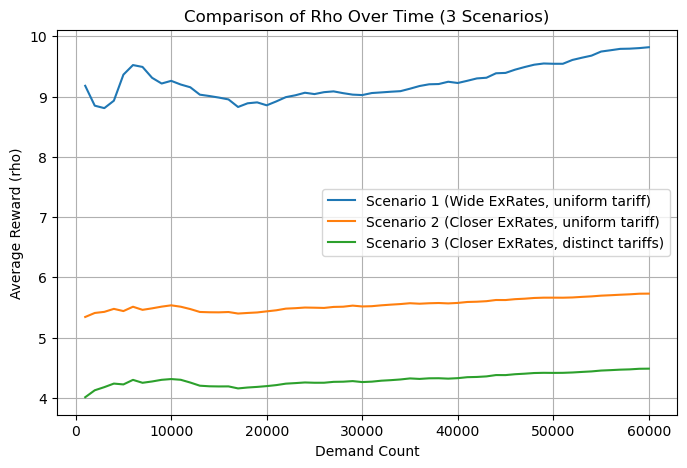

In [7]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# PARAMETRE VE ORTAK SABİTLER
###############################################################################
p            = 500
m            = 300
I            = 10
c            = 6
late_penalty = 3

NUM_COUNTRY = 3
NUM_STOCK   = 5
NUM_ACTION  = 5

ALPHA      = 0.1
GAMMA      = 1.0
EPS_DECAY  = 0.999999
EPS_MIN    = 0.01

SIM_TIME   = 100000
K_SHAPE    = 5
BETA_SCALE = 1.0

# Stok tutma zaman katsayıları
it_list = [0.1715, 0.3430, 0.6860]

###############################################################################
# SCENARIO TANIMLARI
###############################################################################
# 1) SCENARIO 1 => Geniş kur farkları (0.4..0.6, 0.9..1.1, 1.9..2.1), uniform TARIFF=0.15
def random_exchange_scenario1(i):
    if i == 0:
        return random.uniform(0.4, 0.6)
    elif i == 1:
        return random.uniform(0.9, 1.1)
    else:
        return random.uniform(1.9, 2.1)

def tariff_scenario1(i, ex_j):
    # Her zaman 0.15 * ex_j * p
    return 0.15

# 2) SCENARIO 2 => Daha yakın kurlar (0.8..1.0, 0.9..1.1, 0.7..0.9), uniform TARIFF=0.15
def random_exchange_scenario2(i):
    if i == 0:
        return random.uniform(0.8, 1.0)
    elif i == 1:
        return random.uniform(0.9, 1.1)
    else:
        return random.uniform(0.7, 0.9)

def tariff_scenario2(i, ex_j):
    return 0.15

# 3) SCENARIO 3 => Daha yakın kurlar (0.8..1.0, 0.9..1.1, 0.7..0.9), 
#                  ancak distinct tariff => i=0 =>0.10, i=1 =>0.15, i=2 =>0.30
def random_exchange_scenario3(i):
    if i == 0:
        return random.uniform(0.8, 1.0)
    elif i == 1:
        return random.uniform(0.9, 1.1)
    else:
        return random.uniform(0.7, 0.9)

TARIFFS_3 = [0.10, 0.15, 0.30]
def tariff_scenario3(i, ex_j):
    return TARIFFS_3[i]

###############################################################################
# ORTAK FONKSİYONLAR
###############################################################################
def production_time():
    return random.uniform(1, 3)

def transport_time(action):
    # action=0 => local => 1..3
    # action=1,3 => slow => 15..17
    # action=2,4 => fast => 3..5
    if action == 0:
        return random.uniform(1, 3)
    elif action in [1, 3]:
        return random.uniform(15, 17)
    else:
        return random.uniform(3, 5)

def get_j(i, a):
    # action=0 => local => j=i
    if a == 0:
        return i
    if i == 0:
        return 1 if a in [1,2] else 2
    elif i == 1:
        return 0 if a in [1,2] else 2
    else: # i=2
        return 0 if a in [1,2] else 1

###############################################################################
def run_scenario(rand_exch_func, tariff_func, sim_time=SIM_TIME, 
                 record_step=1000):
    """
    Bir senaryoyu (kur fonksiyonu + tarife fonksiyonu) koşturup,
    zaman içinde rho değerlerini kaydeder.
    record_step => her N talepte 1 kez kaydediyoruz.
    """
    # Global benzeri parametreleri burada sıfırlayacağız:
    Q = np.zeros((NUM_COUNTRY, NUM_STOCK, NUM_ACTION))
    EPSILON = 1.0
    TOTAL_REWARD = 0.0
    TOTAL_TIME   = 0.0
    rho          = 0.0

    # Zaman içinde rho kaydı
    demand_count = 0
    arrivals_list = []
    rho_list      = []

    def best_action(i, s):
        return np.argmax(Q[i, s, :])

    def select_action(i, s):
        nonlocal EPSILON
        if random.random() < EPSILON:
            return random.randint(0,4)
        else:
            return best_action(i,s)

    def update_q(i, s, a, reward, dt, i_next, s_next):
        nonlocal TOTAL_REWARD, TOTAL_TIME, rho
        oldQ    = Q[i, s, a]
        bestNxt = np.max(Q[i_next, s_next, :])
        Q[i, s, a] = (1 - ALPHA)*oldQ + ALPHA*(reward - rho*dt + bestNxt)

        TOTAL_REWARD += reward
        TOTAL_TIME   += dt
        T = max(TOTAL_TIME, 1e-9)
        rho = TOTAL_REWARD / T

    def compute_reward(i, a, s):
        pt = production_time()
        st = transport_time(a)
        total_t = pt + st
        late = (total_t > 10)

        j = get_j(i, a)

        ex_i = rand_exch_func(i)
        ex_j = rand_exch_func(j)

        revenue = ex_j * p
        cost    = ex_i*m + I*ex_i*it_list[i] + c*(pt+st) + I*ex_j*it_list[j]

        if i != j:
            tar_rate = tariff_func(i, ex_j)  # senaryoya göre tarife
            cost += tar_rate * ex_j * p

        if late:
            cost += ex_j * late_penalty

        return (revenue - cost), total_t, late

    import simpy
    env = simpy.Environment()

    # Demand process
    def demand_process(env, d_id, i_country):
        nonlocal EPSILON, demand_count
        s = random.randint(0,4)
        a = select_action(i_country, s)
        r, dt, late = compute_reward(i_country, a, s)

        s_next = s - 1 if s>0 else 0
        i_next = i_country

        yield env.timeout(dt)
        update_q(i_country, s, a, r, dt, i_next, s_next)

        if EPSILON > EPS_MIN:
            EPSILON *= EPS_DECAY

        demand_count += 1
        if demand_count % record_step == 0:
            arrivals_list.append(demand_count)
            rho_list.append(rho)

    def arrival_process(env, i_country, k_shape, beta_scale):
        d_id = 0
        while True:
            inter = random.gammavariate(k_shape, beta_scale)
            yield env.timeout(inter)
            d_id += 1
            env.process(demand_process(env, d_id, i_country))

    # Başlat
    for i_country in range(NUM_COUNTRY):
        env.process(arrival_process(env, i_country, K_SHAPE, BETA_SCALE))

    random.seed(42)
    env.run(until=sim_time)

    return arrivals_list, rho_list

###############################################################################
def main():
    # 1) SENARYO 1 => Geniş Kur + Tekdüze 0.15 Tarife
    arr1, rho1 = run_scenario(random_exchange_scenario1, tariff_scenario1)

    # 2) SENARYO 2 => Yakın Kur + Tekdüze 0.15 Tarife
    arr2, rho2 = run_scenario(random_exchange_scenario2, tariff_scenario2)

    # 3) SENARYO 3 => Yakın Kur + Farklı Tarife (0.10, 0.15, 0.30)
    arr3, rho3 = run_scenario(random_exchange_scenario3, tariff_scenario3)

    # ÇİZGİ GRAFİK
    plt.figure(figsize=(8,5))
    plt.plot(arr1, rho1, label="Scenario 1 (Wide ExRates, uniform tariff)")
    plt.plot(arr2, rho2, label="Scenario 2 (Closer ExRates, uniform tariff)")
    plt.plot(arr3, rho3, label="Scenario 3 (Closer ExRates, distinct tariffs)")
    plt.xlabel("Demand Count")
    plt.ylabel("Average Reward (rho)")
    plt.title("Comparison of Rho Over Time (3 Scenarios)")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
